In [15]:
# lib
import numpy as np
import matplotlib.pyplot as plt
import torch

In [16]:
# def

# config

num_positions = 30
d_model = 100

def cosine_similarity(vec1, vec2):
    vec1_norm = np.linalg.norm(vec1) + 0.00000000001
    vec2_norm = np.linalg.norm(vec2) + 0.00000000001
    return np.dot(vec1, vec2) / (vec1_norm * vec2_norm)
def cosine_similarity_matrix(vectors):
    return np.array([[cosine_similarity(vec1, vec2) for vec2 in vectors] for vec1 in vectors])


def plot(x, title=''):
  plt.figure(figsize=(7,4))
  plt.pcolormesh(x,
                # Use a diverging colormap so it's clear where zero is.
                cmap='RdBu', vmin=-1, vmax=1)
  plt.xlim([0,d_model])
  plt.ylabel('num_positions')
  plt.xlabel('d_model')
  plt.title(title)

  plt.colorbar()

def plot_similarity(x, title):
  similarity_matrix = cosine_similarity_matrix(x)
  plt.figure(figsize=(5,4))
  plt.pcolormesh(similarity_matrix,
                # Use a diverging colormap so it's clear where zero is.
                cmap='RdBu', vmin=-1, vmax=1)
  plt.xlim([0,num_positions])
  plt.ylabel(num_positions)
  plt.xlabel(num_positions)
  plt.title(f'plot_similarity {title}')
  plt.colorbar()



In [17]:


# origin_x = np.random.rand(num_positions, d_model) - np.random.rand(num_positions, d_model)
origin_x = np.ones((num_positions, d_model))
print(origin_x.shape)

(30, 100)


1.  position ecoding



\begin{align*}
    PE_{(pos,2i)} = sin(pos / 10000^{2i/dmodel}) \\
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/dmodel})
\end{align*}

In [18]:
i_s = np.arange(d_model//2)
# print(i_s)
min_rate = 1/10000
exponents = (2 / d_model) * i_s # [0, 1]
# print(exponents)
omegas = min_rate**exponents # [1, 0.0001]
omegas = omegas[np.newaxis, :]
# print(omegas, omegas.shape)


In [19]:
positions = np.arange(num_positions)
positions = positions[:, np.newaxis]
# print(positions, positions.shape)
# print((positions/omegas))
sines = np.sin(positions*omegas)
cosines = np.cos(positions*omegas)
# print(sines)
# print(cosines)
pos_encoding = np.concatenate([sines, cosines], axis=-1)
pos_encoding_ziped = np.reshape(np.stack((sines, cosines), axis=-1), (num_positions, d_model))



# print(pos_encoding, pos_encoding.shape)

In [20]:
xs_positioned = pos_encoding + origin_x
xs_positioned_ziped = pos_encoding_ziped + origin_x


origin_x norm [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
origin_x xs_positioned [15.8113883  16.06361273 16.05115488 15.84985157 15.61526728 15.47691315
 15.45692458 15.48093534 15.46367584 15.38377705 15.2887008  15.23839115
 15.24476738 15.26433475 15.24621243 15.18313736 15.11631402 15.09195657
 15.11311723 15.13618654 15.1156073  15.05078849 14.9887853  14.97841761
 15.01888734 15.0563393  15.03497126 14.95354882 14.87306784 14.86337285]


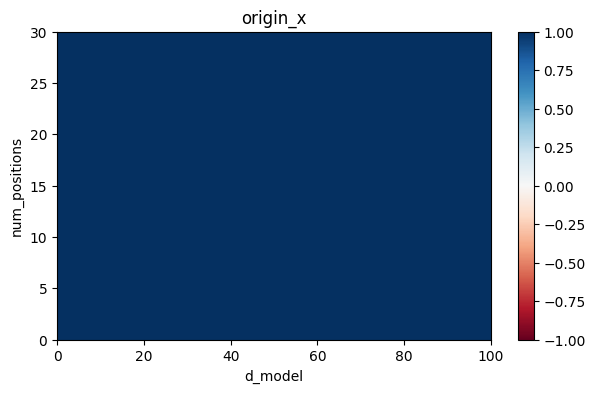

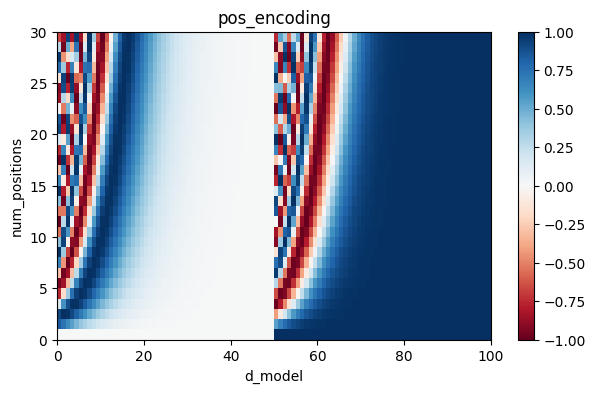

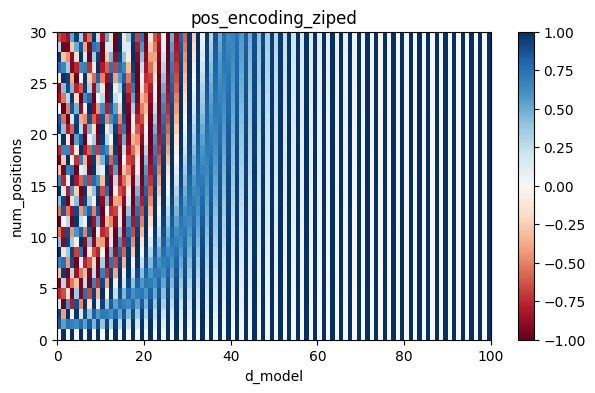

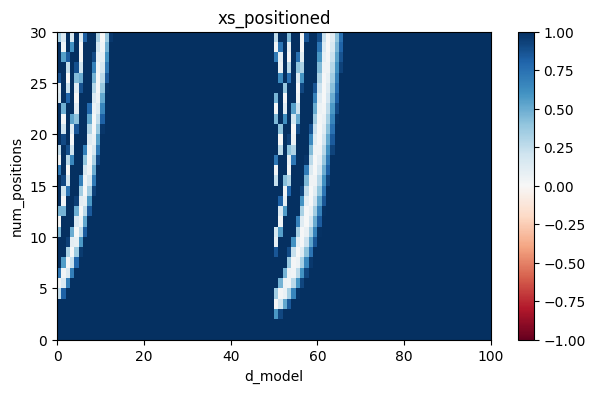

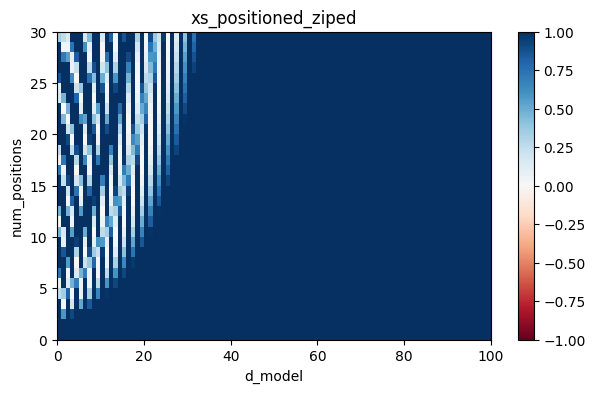

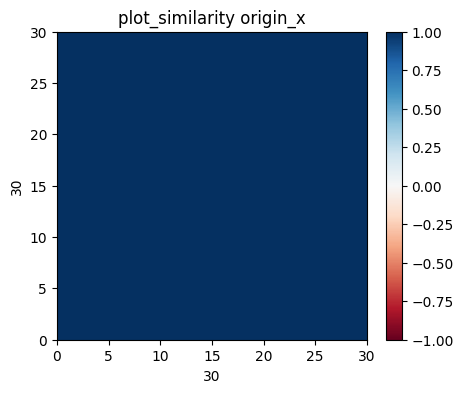

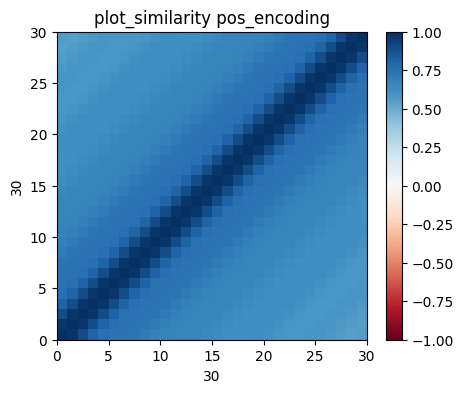

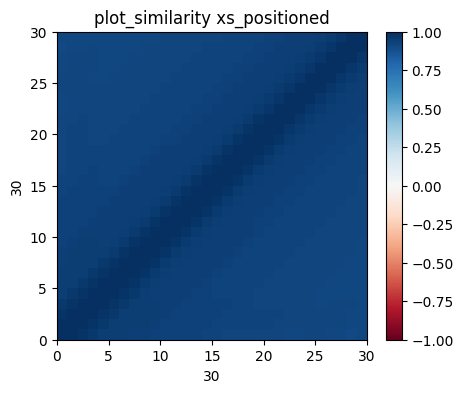

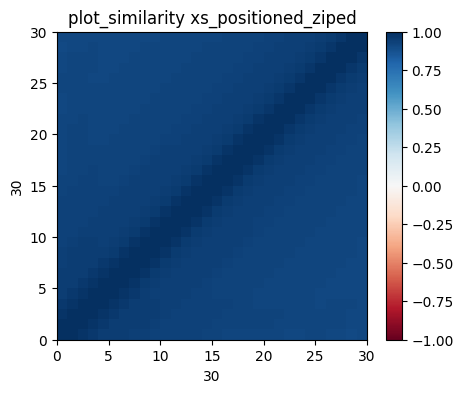

In [21]:
print('origin_x norm', np.linalg.norm(origin_x,axis=1))
print('origin_x xs_positioned', np.linalg.norm(xs_positioned,axis=1))

plot(origin_x, 'origin_x')
plot(pos_encoding, 'pos_encoding')
plot(pos_encoding_ziped, 'pos_encoding_ziped')
plot(xs_positioned, 'xs_positioned')
plot(xs_positioned_ziped, 'xs_positioned_ziped')
plot_similarity(origin_x, 'origin_x')
plot_similarity(pos_encoding, 'pos_encoding')
plot_similarity(xs_positioned, 'xs_positioned')
plot_similarity(xs_positioned_ziped, 'xs_positioned_ziped')




2. RoPE

https://spaces.ac.cn/archives/8265

In [22]:
thetas = omegas
# print(thetas, thetas.shape)

theta_is =  np.stack((thetas, thetas), axis=-1)
theta_is = np.reshape(theta_is, (1, d_model))

# print(theta_is, theta_is.shape)


In [23]:
def neg_swaped_x(x):
  x = x.transpose()

  triangle = np.arange(d_model)
  x_inter_nagtive = np.where(triangle % 2 == 0, -1, 1)
  # print(x_inter_nagtive, x_inter_nagtive.shape)

  rs = np.arange(d_model)
  filter_0 = np.where(rs % 2 == 0, True, False)
  filter_1 = np.where(rs % 2 == 1, True, False)
  # print(filter_0)
  # print(filter_1)
  x0 = x[filter_0]
  x1 = x[filter_1]

  x_new =  np.stack((x1, x0), axis=-1)
  x_new = np.reshape(x_new, (num_positions, d_model))
  x_new = x_new * x_inter_nagtive
  # print(x_new)
  return x_new



origin_x norm [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
origin_x x_roped [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


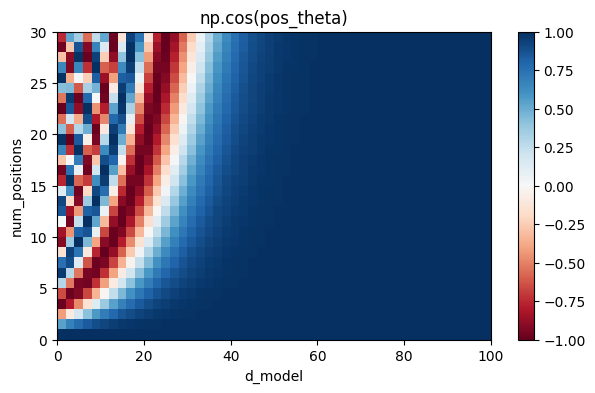

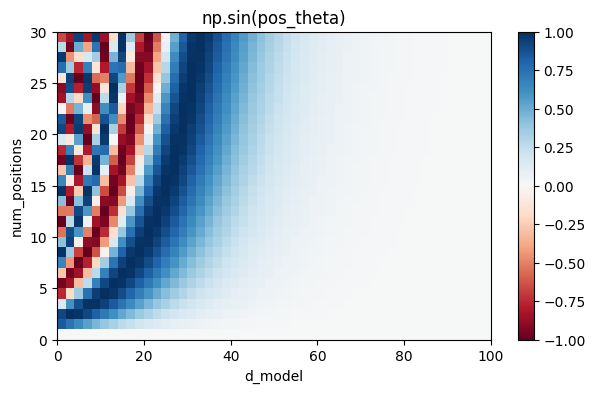

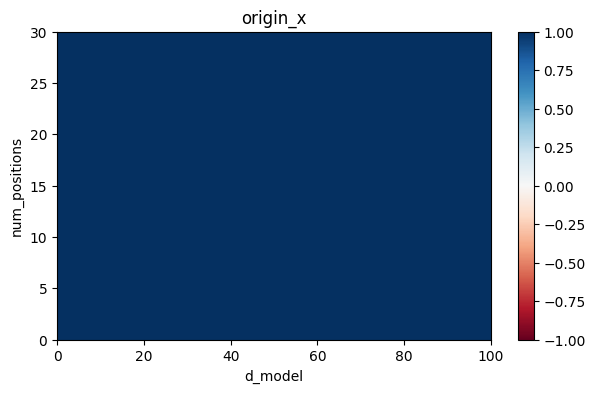

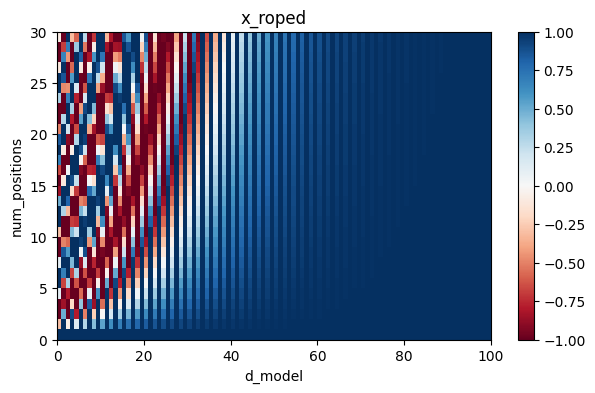

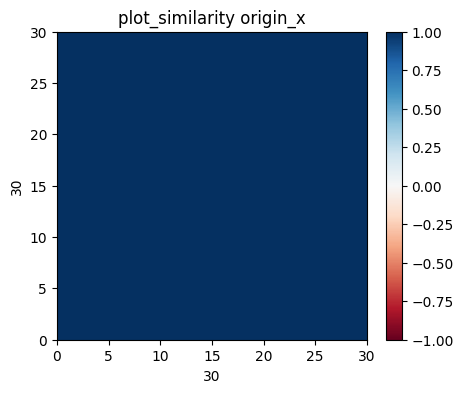

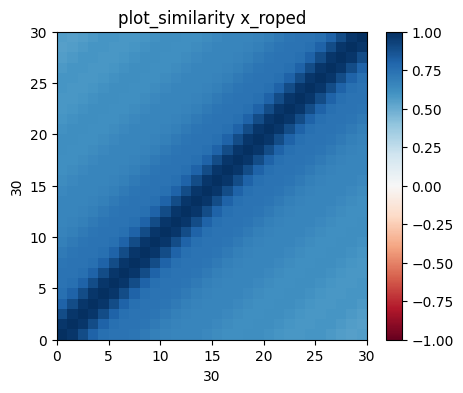

In [24]:

# print(positions, positions.shape)
# print(theta_is, theta_is.shape)

pos_theta = positions * theta_is
# print(pos_theta, pos_theta.shape)


x_1 = origin_x * np.cos(pos_theta)
x_2 = neg_swaped_x(origin_x) * np.sin(pos_theta)
x_roped = x_1 + x_2

plot(np.cos(pos_theta), 'np.cos(pos_theta)')
plot(np.sin(pos_theta), 'np.sin(pos_theta)')

print('origin_x norm', np.linalg.norm(origin_x,axis=1))
print('origin_x x_roped', np.linalg.norm(x_roped,axis=1))

plot(origin_x, 'origin_x')
plot(x_roped, 'x_roped')
plot_similarity(origin_x, 'origin_x')
plot_similarity(x_roped, 'x_roped')





